In [3]:

# Importing Libraries

import pandas as pd
import numpy as np
from datetime import datetime
import tqdm
import re
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from scipy import spatial
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from prettytable import PrettyTable
from tqdm import tqdm
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")



In [6]:
column  = ['clicks', 'impressions', 'AdURL', 'AdId', 'AdvId', 'Depth', 'Pos', 'QId', 'KeyId', 'TitleId', 'DescId', 'UId']
train   = pd.read_csv('../Data/training.txt', sep='\t', header=None, names=column,nrows = 1000000)
train.head()

,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,DescId,UId
0,0,1,4298118681424644510,7686695,385,3,3,1601,5521,7709,576,490234
1,0,1,4860571499428580850,21560664,37484,2,2,2255103,317,48989,44771,490234
2,0,1,9704320783495875564,21748480,36759,3,3,4532751,60721,685038,29681,490234
3,0,1,13677630321509009335,3517124,23778,3,1,1601,2155,1207,1422,490234
4,0,1,3284760244799604489,20758093,34535,1,1,4532751,77819,266618,222223,490234


In [7]:
train  = train.reset_index()
train

,index,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,DescId,UId
0,0,0,1,4298118681424644510,7686695,385,3,3,1601,5521,7709,576,490234
1,1,0,1,4860571499428580850,21560664,37484,2,2,2255103,317,48989,44771,490234
2,2,0,1,9704320783495875564,21748480,36759,3,3,4532751,60721,685038,29681,490234
3,3,0,1,13677630321509009335,3517124,23778,3,1,1601,2155,1207,1422,490234
4,4,0,1,3284760244799604489,20758093,34535,1,1,4532751,77819,266618,222223,490234
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,0,1,12057878999086460853,20180590,27961,3,2,83,34,328,455,5284903
999996,999996,0,1,10349468651765658911,21522776,37422,3,1,0,0,25,4,8522992
999997,999997,0,1,12057878999086460853,20157587,27961,3,3,0,0,7,14,8522992
999998,999998,0,1,15785112999276740221,20908196,35088,3,2,0,0,2,5,8522992


In [8]:
for index, row in train.iterrows():
    if row['impressions'] > 1:
        train = train.append([row]*(int(row['impressions']-1)),ignore_index=True)
        
    if index%10000 == 0:
        print("Rows completed : ", index)

Rows completed :  0
Rows completed :  10000
Rows completed :  20000
Rows completed :  30000
Rows completed :  40000
Rows completed :  50000
Rows completed :  60000
Rows completed :  70000
Rows completed :  80000
Rows completed :  90000
Rows completed :  100000
Rows completed :  110000
Rows completed :  120000
Rows completed :  130000
Rows completed :  140000
Rows completed :  150000
Rows completed :  160000
Rows completed :  170000
Rows completed :  180000
Rows completed :  190000
Rows completed :  200000
Rows completed :  210000
Rows completed :  220000
Rows completed :  230000
Rows completed :  240000
Rows completed :  250000
Rows completed :  260000
Rows completed :  270000
Rows completed :  280000
Rows completed :  290000
Rows completed :  300000
Rows completed :  310000
Rows completed :  320000
Rows completed :  330000
Rows completed :  340000
Rows completed :  350000
Rows completed :  360000
Rows completed :  370000
Rows completed :  380000
Rows completed :  390000
Rows completed

In [9]:
train.to_csv('../Data/train_1M.csv',index=False)

In [10]:
data = pd.read_csv("../Data/train_1M.csv",   
                 dtype={'index':np.int64,'AdURL': np.uint64,'AdId':np.int64,'AdvId':np.int64,'Depth':np.int64,'Pos':np.int64,'QId':np.int64,'KeyId':np.int64,'TitleId':np.int64,'DescId':np.int64,'UId':np.int64})

In [12]:
data['class_label'] = 0
data_n = data
data.head()

,index,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,DescId,UId,class_label
0,0,0.0,1.0,4298118681424644608,7686695,385,3,3,1601,5521,7709,576,490234,0
1,1,0.0,1.0,4860571499428580352,21560664,37484,2,2,2255103,317,48989,44771,490234,0
2,2,0.0,1.0,9704320783495874560,21748480,36759,3,3,4532751,60721,685038,29681,490234,0
3,3,0.0,1.0,13677630321509009408,3517124,23778,3,1,1601,2155,1207,1422,490234,0
4,4,0.0,1.0,3284760244799604736,20758093,34535,1,1,4532751,77819,266618,222223,490234,0


In [13]:
indeces = list()

for i, row in data.iterrows():
    if i<1000000:   # no.of original rows(before replication)
        data_n = data
        if row['clicks'] == 0 and row['impressions'] == 1:
            data['class_label'] = 0
        elif row['clicks'] == 1 and row['impressions'] == 1:
            data['class_label'] = 1
        else:
            data_n = data_n.loc[data_n['index']==row['index']]
            if row['clicks']>=1:
                clicks_num = row['clicks']
                data_n = data_n.sample(int(clicks_num))
                ind = data_n.index  # Example: data_n.index -> Int64Index([100000, 30], dtype='int64')
                indeces.extend(ind)
        if i%10000 == 0:
            print("Rows completed : ", i)

Rows completed :  0
Rows completed :  10000
Rows completed :  20000
Rows completed :  30000
Rows completed :  40000
Rows completed :  50000
Rows completed :  60000
Rows completed :  70000
Rows completed :  80000
Rows completed :  90000
Rows completed :  100000
Rows completed :  110000
Rows completed :  120000
Rows completed :  130000
Rows completed :  140000
Rows completed :  150000
Rows completed :  160000
Rows completed :  170000
Rows completed :  180000
Rows completed :  190000
Rows completed :  200000
Rows completed :  210000
Rows completed :  220000
Rows completed :  230000
Rows completed :  240000
Rows completed :  250000
Rows completed :  260000
Rows completed :  270000
Rows completed :  280000
Rows completed :  290000
Rows completed :  300000
Rows completed :  310000
Rows completed :  320000
Rows completed :  330000
Rows completed :  340000
Rows completed :  350000
Rows completed :  360000
Rows completed :  370000
Rows completed :  380000
Rows completed :  390000
Rows completed

In [14]:
indeces = list(dict.fromkeys(indeces))
indeces

[33,
 1000004,
 112,
 234,
 346,
 1000093,
 494,
 646,
 665,
 1000152,
 1000169,
 1000178,
 1017,
 1000195,
 1000200,
 1000190,
 1000199,
 1000193,
 1000196,
 1000191,
 1000198,
 1081,
 1105,
 1000258,
 1000329,
 1000347,
 1731,
 1000425,
 2440,
 2725,
 1000568,
 3128,
 1000640,
 1000647,
 3460,
 3465,
 1000714,
 1000716,
 1000717,
 3530,
 1000721,
 1000783,
 4005,
 1000792,
 1000801,
 4277,
 4345,
 1000877,
 4353,
 4445,
 1000987,
 4715,
 1000989,
 1001022,
 1000993,
 1000991,
 1001016,
 1001015,
 1001007,
 1001012,
 1001001,
 4716,
 1001023,
 1001006,
 4718,
 1001024,
 1001045,
 5291,
 5345,
 5619,
 1001169,
 1001176,
 5920,
 1001238,
 6485,
 1001285,
 6599,
 6703,
 1001310,
 1001359,
 6942,
 1001378,
 7012,
 1001387,
 7057,
 1001449,
 7479,
 7793,
 1001519,
 7943,
 1001560,
 1001564,
 8047,
 1001586,
 8168,
 1001650,
 1001662,
 1001691,
 1001706,
 1001734,
 9079,
 1001746,
 9186,
 1001749,
 9199,
 1001764,
 1001776,
 9249,
 9254,
 1001786,
 1001800,
 1001817,
 1001865,
 9935,
 10018

In [32]:
data['CTR'] = data['clicks'] * 1.0 / data['impressions']

#adding relative position as a new feature
data['RPosition'] = data['Depth'] - data['Pos'] * 1.0 / data['Depth']

# Add predicted CTR as #clicks + ab / #impressions + b
data['pCTR'] = (1.0 * data['clicks'] + 0.05 * 75) / (data['impressions'] + 75)

data.head()

,index,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,DescId,UId,class_label,CTR,RPosition,pCTR
0,0,0.0,1.0,4298118681424644608,7686695,385,3,3,1601,5521,7709,576,490234,0,0.0,2.000000,0.049342
1,1,0.0,1.0,4860571499428580352,21560664,37484,2,2,2255103,317,48989,44771,490234,0,0.0,1.000000,0.049342
2,2,0.0,1.0,9704320783495874560,21748480,36759,3,3,4532751,60721,685038,29681,490234,0,0.0,2.000000,0.049342
3,3,0.0,1.0,13677630321509009408,3517124,23778,3,1,1601,2155,1207,1422,490234,0,0.0,2.666667,0.049342
4,4,0.0,1.0,3284760244799604736,20758093,34535,1,1,4532751,77819,266618,222223,490234,0,0.0,0.000000,0.049342


In [39]:
cols = data.columns.tolist()
cols.remove('class_label')
cols.append('class_label')
print(cols)
data = data[cols]
data.head()

['index', 'clicks', 'impressions', 'AdURL', 'AdId', 'AdvId', 'Depth', 'Pos', 'QId', 'KeyId', 'TitleId', 'DescId', 'UId', 'CTR', 'RPosition', 'pCTR', 'class_label']


,index,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,DescId,UId,CTR,RPosition,pCTR,class_label
0,0,0.0,1.0,4298118681424644608,7686695,385,3,3,1601,5521,7709,576,490234,0.0,2.000000,0.049342,0
1,1,0.0,1.0,4860571499428580352,21560664,37484,2,2,2255103,317,48989,44771,490234,0.0,1.000000,0.049342,0
2,2,0.0,1.0,9704320783495874560,21748480,36759,3,3,4532751,60721,685038,29681,490234,0.0,2.000000,0.049342,0
3,3,0.0,1.0,13677630321509009408,3517124,23778,3,1,1601,2155,1207,1422,490234,0.0,2.666667,0.049342,0
4,4,0.0,1.0,3284760244799604736,20758093,34535,1,1,4532751,77819,266618,222223,490234,0.0,0.000000,0.049342,0


In [40]:
data.iloc[indeces,16] = 1

In [0]:
#duplicateRowsDF = data[data.duplicated(['AdURL','AdId', 'AdvId','UId','QId','KeyId','TitleId','DescId','Depth','Pos','impressions'])]
#duplicateRowsDF = data[data.duplicated(['index'])]

# data_n= data_n.loc[data_n['index']==30]
# data_n = data_n.sample(2)
# data_n['label']=1

In [42]:
data.to_csv('../Data/train_1M_labeled.csv',index=False)

In [43]:
data = pd.read_csv('../Data/train_1M_labeled.csv')
data.head()

,index,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,DescId,UId,CTR,RPosition,pCTR,class_label
0,0,0.0,1.0,4298118681424644608,7686695,385,3,3,1601,5521,7709,576,490234,0.0,2.000000,0.049342,0
1,1,0.0,1.0,4860571499428580352,21560664,37484,2,2,2255103,317,48989,44771,490234,0.0,1.000000,0.049342,0
2,2,0.0,1.0,9704320783495874560,21748480,36759,3,3,4532751,60721,685038,29681,490234,0.0,2.000000,0.049342,0
3,3,0.0,1.0,13677630321509009408,3517124,23778,3,1,1601,2155,1207,1422,490234,0.0,2.666667,0.049342,0
4,4,0.0,1.0,3284760244799604736,20758093,34535,1,1,4532751,77819,266618,222223,490234,0.0,0.000000,0.049342,0


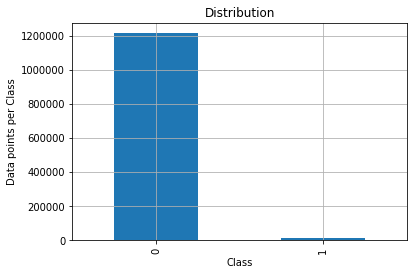

In [44]:
disb = data['class_label'].value_counts().sort_index()

my_colors = 'rgbkymc'
disb.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution')
plt.grid()
plt.show()

In [45]:
data['class_label'].value_counts()

0    1215292
1      11429
Name: class_label, dtype: int64

In [46]:
total_impressions = data['impressions'].sum()
total_clicks      = data['clicks'].sum()
net_CTR           = total_clicks * 1.0 / total_impressions

print( ('Net CTR: {0}'.format(round(net_CTR*100,2))), '%')

Net CTR: 3.01 %


In [47]:
# total no. of unique users in the dataset...
print( 'Total no. of unique users:', len(data.groupby('UId')))

# total no. of unique queries in the dataset...
print( 'Total no. of unique queries:', len(data.groupby('QId')))

# total no. of unique advertisements in the dataset...
print( 'Total no. of unique ads:', len(data.groupby('AdId')))

# total no. of unique advertisers in the dataset...
print( 'Total no. of unique advertisers:', len(data.groupby('AdvId')))

Total no. of unique users: 202547
Total no. of unique queries: 279352
Total no. of unique ads: 99242
Total no. of unique advertisers: 12193


In [ ]:
sns.kdeplot(data['CTR'])
plt.show()

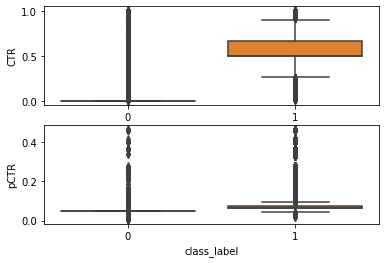

In [51]:
f, (ax1, ax2) = plt.subplots(2)
sns.boxplot(x='class_label', y='CTR', data=data,ax=ax1)
sns.boxplot(x='class_label', y='pCTR', data=data,ax=ax2)

plt.show()

The adds which have high CTR got clicked

### Train Test Split

In [52]:
y_true = data['class_label'].values

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
x_train, x_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.20)

In [53]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(981376, 17)
(245345, 17)
(981376,)
(245345,)


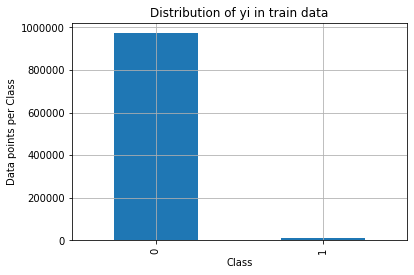

Number of data points in class 0 : 972233 ( 99.068 %)
Number of data points in class 1 : 9143 ( 0.932 %)
--------------------------------------------------------------------------------


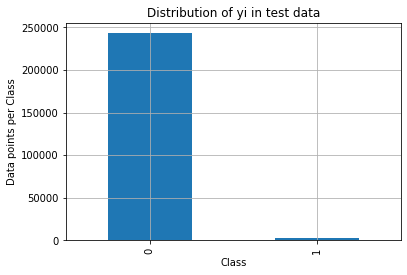

Number of data points in class 0 : 243059 ( 99.068 %)
Number of data points in class 1 : 2286 ( 0.932 %)


In [56]:
train_class_distribution = x_train['class_label'].value_counts().sort_index()
test_class_distribution = x_test['class_label'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values) #Return a Numpy representation of the DataFrame
for i in sorted_yi:
    print('Number of data points in class', i, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/x_train.shape[0]*100), 3), '%)')


print('-'*80)


my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/x_test.shape[0]*100), 3), '%)')


In [57]:
x_train['CTR'] = x_train['clicks'] * 1.0 / x_train['impressions']

#adding relative position as a new feature
x_train['RPosition'] = x_train['Depth'] - x_train['Pos'] * 1.0 / x_train['Depth']

# Add predicted CTR as #clicks + ab / #impressions + b
x_train['pCTR'] = (1.0 * x_train['clicks'] + 0.05 * 75) / (x_train['impressions'] + 75)

x_train.head()

,index,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,DescId,UId,CTR,RPosition,pCTR,class_label
147640,147640,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,1637,5315,874413,0.0,1.0,0.049342,0
930798,930798,0.0,1.0,17199765659282124800,21314301,8148,2,1,2185,337,48230,23504,6526684,0.0,1.5,0.049342,0
623253,623253,0.0,1.0,14340390157469405184,21163927,23808,2,1,8866022,39631,80674,127,11833968,0.0,1.5,0.049342,0
1125933,566244,0.0,3.0,3089000650796075008,21211390,14327,2,2,199059,15580,12383,7246,98633,0.0,1.0,0.048077,0
22091,22091,0.0,2.0,14340390157469405184,9027213,23808,2,1,5,1,0,0,93960,0.0,1.5,0.048701,0


In [58]:
x_test['CTR'] = x_test['clicks'] * 1.0 / x_test['impressions']

#adding relative position as a new feature
x_test['RPosition'] = x_test['Depth'] - x_test['Pos'] * 1.0 / x_test['Depth']

# Add predicted CTR as #clicks + ab / #impressions + b
x_test['pCTR'] = (1.0 * x_test['clicks'] + 0.05 * 75) / (x_test['impressions'] + 75)

x_test.head()

,index,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,DescId,UId,CTR,RPosition,pCTR,class_label
1143994,643621,0.0,2.0,12057878999086460928,20163220,27961,1,1,13343988,359,422,602,2107492,0.0,0.0,0.048701,0
278798,278798,0.0,1.0,14340390157469405184,9027437,23808,2,1,3968,300,20,20,260814,0.0,1.5,0.049342,0
1184987,820135,0.0,2.0,4326317763394939904,21920415,38054,2,2,3598,2175,4449,1881,329589,0.0,1.0,0.048701,0
191225,191225,0.0,1.0,13090221289647714304,20174982,23795,1,1,120235,1198,3,7,6293969,0.0,0.0,0.049342,0
247294,247294,0.0,1.0,4298118681424644608,3703030,385,3,3,8035919,220342,589448,484734,26605,0.0,2.0,0.049342,0


In [59]:
print(x_train.shape)
print(x_test.shape)

(981376, 17)
(245345, 17)


In [61]:
def count(sentence):
    '''
        (str) -> (int)
        Returns no. of words in a sentence.
    '''
    return len(str(sentence).split('|'))




# Load User Data..

user_col  = ['UId', 'Gender', 'Age']
user      = pd.read_csv('../Data/userid_profile.txt', sep='\t', header=None, names=user_col)

# Load Query Data..

query_col = ['QId', 'Query']
query     = pd.read_csv('../Data/queryid_tokensid.txt', sep='\t', header=None, names=query_col)

# Load Ad Description Data..

desc_col  = ['DescId', 'Description']
desc      = pd.read_csv('../Data/descriptionid_tokensid.txt', sep='\t', header=None, names=desc_col)

# Load Ad Title Data..

title_col = ['TitleId', 'Title']
title     = pd.read_csv('../Data/titleid_tokensid.txt', sep='\t', header=None, names=title_col)

# Load Keyword Data..

key_col  = ['KeyId', 'Keyword']
keyword  = pd.read_csv('../Data/purchasedkeywordid_tokensid.txt', sep='\t', header=None, names=key_col)

# Count no. of tokens in a query issued by a user.

query['QCount'] = query['Query'].apply(count)
del query['Query']

# Count no. of tokens in title of an advertisement.

title['TCount'] = title['Title'].apply(count)
del title['Title']

# Count no. of tokens in description of an advertisement.

desc['DCount'] = desc['Description'].apply(count)
del desc['Description']

# Count no. of tokens in purchased keyword.

keyword['KCount'] = keyword['Keyword'].apply(count)
del keyword['Keyword']


In [62]:
x_train  = pd.merge(x_train, user,  on='UId')
x_train  = pd.merge(x_train, query, on='QId')
x_train  = pd.merge(x_train, title, on='TitleId')
x_train  = pd.merge(x_train, desc,  on='DescId')
x_train  = pd.merge(x_train, keyword, on='KeyId')

x_train.head()

,index,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,...,CTR,RPosition,pCTR,class_label,Gender,Age,QCount,TCount,DCount,KCount
0,147640,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,0.0,1.0,0.049342,0,2,4,3,6,15,1
1,555584,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,0.0,1.0,0.049342,0,1,5,3,6,15,1
2,663704,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,0.0,1.0,0.049342,0,1,3,3,6,15,1
3,891038,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,0.0,1.0,0.049342,0,1,5,3,6,15,1
4,932256,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,0.0,1.0,0.049342,0,1,6,3,6,15,1


In [63]:
x_test  = pd.merge(x_test, user,  on='UId')
x_test  = pd.merge(x_test, query, on='QId')
x_test  = pd.merge(x_test, title, on='TitleId')
x_test  = pd.merge(x_test, desc,  on='DescId')
x_test  = pd.merge(x_test, keyword, on='KeyId')

x_test.head()

,index,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,...,CTR,RPosition,pCTR,class_label,Gender,Age,QCount,TCount,DCount,KCount
0,643621,0.0,2.0,12057878999086460928,20163220,27961,1,1,13343988,359,...,0.0,0.0,0.048701,0,1,5,2,6,14,1
1,574372,0.0,1.0,12057878999086460928,20163220,27961,1,1,772098,359,...,0.0,0.0,0.049342,0,2,5,2,6,14,1
2,376084,0.0,2.0,12057878999086460928,20163220,27961,1,1,4755543,359,...,0.0,0.0,0.048701,0,2,5,2,6,14,1
3,432568,0.0,1.0,12057878999086460928,20163220,27961,1,1,23682234,359,...,0.0,0.0,0.049342,0,2,3,2,6,14,1
4,532528,0.0,1.0,12057878999086460928,20163220,27961,1,1,23680882,359,...,0.0,0.0,0.049342,0,2,1,2,6,14,1


In [64]:
x_train.isnull().sum()

index          0
clicks         0
impressions    0
AdURL          0
AdId           0
AdvId          0
Depth          0
Pos            0
QId            0
KeyId          0
TitleId        0
DescId         0
UId            0
CTR            0
RPosition      0
pCTR           0
class_label    0
Gender         0
Age            0
QCount         0
TCount         0
DCount         0
KCount         0
dtype: int64

In [66]:
# checking the null values in every column of x_test
x_test.isnull().sum()

index          0
clicks         0
impressions    0
AdURL          0
AdId           0
AdvId          0
Depth          0
Pos            0
QId            0
KeyId          0
TitleId        0
DescId         0
UId            0
CTR            0
RPosition      0
pCTR           0
class_label    0
Gender         0
Age            0
QCount         0
TCount         0
DCount         0
KCount         0
dtype: int64

### Feature Engineering

In [70]:
def features(data_1,temp,key,op):
    temp_data = temp.groupby(key).agg([op])
    temp_df = pd.DataFrame()
    temp_df[key] = temp_data.index
    temp_df['values'] = np.asarray(temp_data)   
    temp = pd.merge(temp,temp_df, on=key, how='left')
    return temp['values']

In [71]:
x_train['mAdURL']     = features(x_train,x_train[['AdURL', 'CTR']],'AdURL','mean')
x_train['mAdId']      = features(x_train,x_train[['AdId', 'CTR']],'AdId','mean')
x_train['mAdvId']     = features(x_train,x_train[['AdvId', 'CTR']],'AdvId','mean')
x_train['mDepth']     = features(x_train,x_train[['Depth', 'CTR']],'Depth','mean')
x_train['mPos']       = features(x_train,x_train[['Pos', 'CTR']],'Pos','mean')
x_train['mQId']       = features(x_train,x_train[['QId', 'CTR']],'QId','mean')
x_train['mKeyId']     = features(x_train,x_train[['KeyId', 'CTR']],'KeyId','mean')
x_train['mTitleId']   = features(x_train,x_train[['TitleId', 'CTR']],'TitleId','mean')
x_train['mDescId']    = features(x_train,x_train[['DescId', 'CTR']],'DescId','mean')
x_train['mUId']       = features(x_train,x_train[['UId', 'CTR']],'UId','mean')
x_train['mRPosition'] = features(x_train,x_train[['RPosition', 'CTR']],'RPosition','mean')
x_train['mGender']    = features(x_train,x_train[['Gender', 'CTR']],'Gender','mean')
x_train['mAge']       = features(x_train,x_train[['Age', 'CTR']],'Age','mean')

x_train['pAdURL']     = features(x_train,x_train[['AdURL', 'pCTR']],'AdURL','mean')
x_train['pAdId']      = features(x_train,x_train[['AdId', 'pCTR']],'AdId','mean')
x_train['pAdvId']     = features(x_train,x_train[['AdvId', 'pCTR']],'AdvId','mean')
x_train['pDepth']     = features(x_train,x_train[['Depth', 'pCTR']],'Depth','mean')
x_train['pPos']       = features(x_train,x_train[['Pos', 'pCTR']],'Pos','mean')
x_train['pQId']       = features(x_train,x_train[['QId', 'pCTR']],'QId','mean')
x_train['pKeyId']     = features(x_train,x_train[['KeyId', 'pCTR']],'KeyId','mean')
x_train['pTitleId']   = features(x_train,x_train[['TitleId', 'pCTR']],'TitleId','mean')
x_train['pDescId']    = features(x_train,x_train[['DescId', 'pCTR']],'DescId','mean')
x_train['pUId']       = features(x_train,x_train[['UId', 'pCTR']],'UId','mean')
x_train['pRPosition'] = features(x_train,x_train[['RPosition', 'pCTR']],'RPosition','mean')
x_train['pGender']    = features(x_train,x_train[['Gender', 'pCTR']],'Gender','mean')
x_train['pAge']       = features(x_train,x_train[['Age', 'pCTR']],'Age','mean')

# Test Features

x_test['mAdURL']     = features(x_test,x_train[['AdURL', 'CTR']],'AdURL','mean')
x_test['mAdId']      = features(x_test,x_train[['AdId', 'CTR']],'AdId','mean')
x_test['mAdvId']     = features(x_test,x_train[['AdvId', 'CTR']],'AdvId','mean')
x_test['mDepth']     = features(x_test,x_train[['Depth', 'CTR']],'Depth','mean')
x_test['mPos']       = features(x_test,x_train[['Pos', 'CTR']],'Pos','mean')
x_test['mQId']       = features(x_test,x_train[['QId', 'CTR']],'QId','mean')
x_test['mKeyId']     = features(x_test,x_train[['KeyId', 'CTR']],'KeyId','mean')
x_test['mTitleId']   = features(x_test,x_train[['TitleId', 'CTR']],'TitleId','mean')
x_test['mDescId']    = features(x_test,x_train[['DescId', 'CTR']],'DescId','mean')
x_test['mUId']       = features(x_test,x_train[['UId', 'CTR']],'UId','mean')
x_test['mRPosition'] = features(x_test,x_train[['RPosition', 'CTR']],'RPosition','mean')
x_test['mGender']    = features(x_test,x_train[['Gender', 'CTR']],'Gender','mean')
x_test['mAge']       = features(x_test,x_train[['Age', 'CTR']],'Age','mean')

x_test['pAdURL']     = features(x_test,x_train[['AdURL', 'pCTR']],'AdURL','mean')
x_test['pAdId']      = features(x_test,x_train[['AdId', 'pCTR']],'AdId','mean')
x_test['pAdvId']     = features(x_test,x_train[['AdvId', 'pCTR']],'AdvId','mean')
x_test['pDepth']     = features(x_test,x_train[['Depth', 'pCTR']],'Depth','mean')
x_test['pPos']       = features(x_test,x_train[['Pos', 'pCTR']],'Pos','mean')
x_test['pQId']       = features(x_test,x_train[['QId', 'pCTR']],'QId','mean')
x_test['pKeyId']     = features(x_test,x_train[['KeyId', 'pCTR']],'KeyId','mean')
x_test['pTitleId']   = features(x_test,x_train[['TitleId', 'pCTR']],'TitleId','mean')
x_test['pDescId']    = features(x_test,x_train[['DescId', 'pCTR']],'DescId','mean')
x_test['pUId']       = features(x_test,x_train[['UId', 'pCTR']],'UId','mean')
x_test['pRPosition'] = features(x_test,x_train[['RPosition', 'pCTR']],'RPosition','mean')
x_test['pGender']    = features(x_test,x_train[['Gender', 'pCTR']],'Gender','mean')
x_test['pAge']       = features(x_test,x_train[['Age', 'pCTR']],'Age','mean')

In [76]:
# only the above features gave the better results when I modelled. So saving these features for future purpose

x_train.to_csv('../Data/train_1M_basic_feat.csv',index=False)
x_test.to_csv('../Data/test_1M_basic_feat.csv',index=False)

In [108]:
# Reading from CSV file

x_train = pd.read_csv("../Data/train_1M_basic_feat.csv")
x_test = pd.read_csv("../Data/test_1M_basic_feat.csv")

#total 49 features

In [109]:
x_train.head()

,index,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,...,pDepth,pPos,pQId,pKeyId,pTitleId,pDescId,pUId,pRPosition,pGender,pAge
0,147640,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,0.049698,0.049367,0.049608,0.049207,0.049221,0.049278,0.049244,0.049362,0.049771,0.049620
1,555584,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,0.049698,0.049367,0.049608,0.049207,0.049221,0.049278,0.049275,0.049362,0.049438,0.049713
2,663704,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,0.049698,0.049367,0.049608,0.049207,0.049221,0.049278,0.049342,0.049362,0.049438,0.049731
3,891038,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,0.049698,0.049367,0.049608,0.049207,0.049221,0.049278,0.049342,0.049362,0.049438,0.049713
4,932256,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,0.049698,0.049367,0.049608,0.049207,0.049221,0.049278,0.049342,0.049362,0.049438,0.049619


In [110]:
x_test.head()

,index,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,...,pDepth,pPos,pQId,pKeyId,pTitleId,pDescId,pUId,pRPosition,pGender,pAge
0,643621,0.0,2.0,12057878999086460928,20163220,27961,1,1,13343988,359,...,0.049698,0.049367,0.049608,0.049207,0.049221,0.049278,0.049244,0.049362,0.049771,0.049620
1,574372,0.0,1.0,12057878999086460928,20163220,27961,1,1,772098,359,...,0.049698,0.049367,0.049608,0.049207,0.049221,0.049278,0.049275,0.049362,0.049438,0.049713
2,376084,0.0,2.0,12057878999086460928,20163220,27961,1,1,4755543,359,...,0.049698,0.049367,0.049608,0.049207,0.049221,0.049278,0.049342,0.049362,0.049438,0.049731
3,432568,0.0,1.0,12057878999086460928,20163220,27961,1,1,23682234,359,...,0.049698,0.049367,0.049608,0.049207,0.049221,0.049278,0.049342,0.049362,0.049438,0.049713
4,532528,0.0,1.0,12057878999086460928,20163220,27961,1,1,23680882,359,...,0.049698,0.049367,0.049608,0.049207,0.049221,0.049278,0.049342,0.049362,0.049438,0.049619


### Tried some more feature engineering

In [111]:
x_train['num_Imp_Ad']         = features(x_train,x_train[['AdId', 'impressions']],'AdId','sum')
x_train['num_Imp_Advertiser'] = features(x_train,x_train[['AdvId', 'impressions']],'AdvId','sum')
x_train['num_Imp_Depth']      = features(x_train,x_train[['Depth', 'impressions']],'Depth','sum')
x_train['num_Imp_Position']   = features(x_train,x_train[['Pos', 'impressions']],'Pos','sum')
x_train['num_Imp_Rposition '] = features(x_train,x_train[['RPosition', 'impressions']],'RPosition','sum')
x_train['num_Imp_UId']      = features(x_train,x_train[['UId', 'impressions']],'UId','sum')

x_test['num_Imp_Ad']         = features(x_test,x_train[['AdId', 'impressions']],'AdId','sum')
x_test['num_Imp_Advertiser'] = features(x_test,x_train[['AdvId', 'impressions']],'AdvId','sum')
x_test['num_Imp_Depth']      = features(x_test,x_train[['Depth', 'impressions']],'Depth','sum')
x_test['num_Imp_Position']   = features(x_test,x_train[['Pos', 'impressions']],'Pos','sum')
x_test['num_Imp_Rposition '] = features(x_test,x_train[['RPosition', 'impressions']],'RPosition','sum')
x_test['num_Imp_UId']      = features(x_test,x_train[['UId', 'impressions']],'UId','sum')

In [112]:
x_train['num_Imp_count_Ad']         = features(x_train,x_train[['AdId', 'impressions']],'AdId','count')
x_train['num_Imp_count_Advertiser'] = features(x_train,x_train[['AdvId', 'impressions']],'AdvId','count')
#x_train['num_Imp_count_Depth']      = features(x_train,x_train[['Depth', 'impressions']],'Depth','count')
#x_train['num_Imp_count_Position']   = features(x_train,x_train[['Pos', 'impressions']],'Pos','count')
#x_train['num_Imp_count_Rposition '] = features(x_train,x_train[['RPosition', 'impressions']],'RPosition','count')
x_train['num_Imp_count_QId']        = features(x_train,x_train[['QId', 'impressions']],'QId','count')
x_train['num_Imp_count_KeyId']      = features(x_train,x_train[['KeyId', 'impressions']],'KeyId','count')
x_train['num_Imp_count_TitleId ']   = features(x_train,x_train[['TitleId', 'impressions']],'TitleId','count')
x_train['num_Imp_count_DescId']     = features(x_train,x_train[['DescId', 'impressions']],'DescId','count')
x_train['num_Imp_count_UId']        = features(x_train,x_train[['UId', 'impressions']],'UId','count')


x_test['num_Imp_count_Ad']         = features(x_test,x_train[['AdId', 'impressions']],'AdId','count')
x_test['num_Imp_count_Advertiser'] = features(x_test,x_train[['AdvId', 'impressions']],'AdvId','count')
#x_test['num_Imp_count_Depth']      = features(x_test,x_train[['Depth', 'impressions']],'Depth','count')
#x_test['num_Imp_count_Position']   = features(x_test,x_train[['Pos', 'impressions']],'Pos','count')
#x_test['num_Imp_count_Rposition '] = features(x_test,x_train[['RPosition', 'impressions']],'RPosition','count')
x_test['num_Imp_count_QId']        = features(x_test,x_train[['QId', 'impressions']],'QId','count')
x_test['num_Imp_count_KeyId']      = features(x_test,x_train[['KeyId', 'impressions']],'KeyId','count')
x_test['num_Imp_count_TitleId ']   = features(x_test,x_train[['TitleId', 'impressions']],'TitleId','count')
x_test['num_Imp_count_DescId']     = features(x_test,x_train[['DescId', 'impressions']],'DescId','count')
x_test['num_Imp_count_UId']        = features(x_test,x_train[['UId', 'impressions']],'UId','count')

In [113]:
x_train['num_click_Ad']         = features(x_train,x_train[['AdId', 'clicks']],'AdId','sum')
x_train['num_click_Advertiser'] = features(x_train,x_train[['AdvId', 'clicks']],'AdvId','sum')
x_train['num_click_QId']        = features(x_train,x_train[['QId', 'clicks']],'QId','sum')
x_train['num_click_KeyId']      = features(x_train,x_train[['KeyId', 'clicks']],'KeyId','sum')
x_train['num_click_TitleId ']   = features(x_train,x_train[['TitleId', 'clicks']],'TitleId','sum')
x_train['num_click_DescId']     = features(x_train,x_train[['DescId', 'clicks']],'DescId','sum')
x_train['num_click_UId']        = features(x_train,x_train[['UId', 'clicks']],'UId','sum')
x_train['num_click_Gender ']    = features(x_train,x_train[['Gender', 'clicks']],'Gender','sum')

x_test['num_click_Ad']          = features(x_test,x_train[['AdId', 'clicks']],'AdId','sum')
x_test['num_click_Advertiser']  = features(x_test,x_train[['AdvId', 'clicks']],'AdvId','sum')
x_test['num_click_QId']         = features(x_test,x_train[['QId', 'clicks']],'QId','sum')
x_test['num_click_KeyId']       = features(x_test,x_train[['KeyId', 'clicks']],'KeyId','sum')
x_test['num_click_TitleId ']    = features(x_test,x_train[['TitleId', 'clicks']],'TitleId','sum')
x_test['num_click_DescId']      = features(x_test,x_train[['DescId', 'clicks']],'DescId','sum')
x_test['num_click_UId']         = features(x_test,x_train[['UId', 'clicks']],'UId','sum')
x_test['num_click_Gender ']     = features(x_test,x_train[['Gender', 'clicks']],'Gender','sum')

In [114]:
x_train['num_count_Ad']         = features(x_train,x_train[['AdId', 'clicks']],'AdId','count')
x_train['num_count_Advertiser'] = features(x_train,x_train[['AdvId', 'clicks']],'AdvId','count')
x_train['num_count_QId']        = features(x_train,x_train[['QId', 'clicks']],'QId','count')
x_train['num_count_KeyId']      = features(x_train,x_train[['KeyId', 'clicks']],'KeyId','count')
x_train['num_count_TitleId ']   = features(x_train,x_train[['TitleId', 'clicks']],'TitleId','count')
x_train['num_count_DescId']     = features(x_train,x_train[['DescId', 'clicks']],'DescId','count')
x_train['num_count_UId']        = features(x_train,x_train[['UId', 'clicks']],'UId','count')

x_test['num_count_Ad']         = features(x_test,x_train[['AdId', 'clicks']],'AdId','count')
x_test['num_count_Advertiser'] = features(x_test,x_train[['AdvId', 'clicks']],'AdvId','count')
x_test['num_count_QId']        = features(x_test,x_train[['QId', 'clicks']],'QId','count')
x_test['num_count_KeyId']      = features(x_test,x_train[['KeyId', 'clicks']],'KeyId','count')
x_test['num_count_TitleId ']   = features(x_test,x_train[['TitleId', 'clicks']],'TitleId','count')
x_test['num_count_DescId']     = features(x_test,x_train[['DescId', 'clicks']],'DescId','count')
x_test['num_count_UId']        = features(x_test,x_train[['UId', 'clicks']],'UId','count')

In [118]:
x_train.head()

,index,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,...,num_click_DescId,num_click_UId,num_click_Gender,num_count_Ad,num_count_Advertiser,num_count_QId,num_count_KeyId,num_count_TitleId,num_count_DescId,num_count_UId
0,147640,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,0.0,0.0,36297.0,44,87481,122,333,53,20,13
1,555584,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,0.0,0.0,41333.0,44,87481,122,333,53,20,19
2,663704,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,0.0,0.0,41333.0,44,87481,122,333,53,20,5
3,891038,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,0.0,0.0,41333.0,44,87481,122,333,53,20,2
4,932256,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,0.0,0.0,41333.0,44,87481,122,333,53,20,2


In [119]:
x_test.head()

,index,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,...,num_click_DescId,num_click_UId,num_click_Gender,num_count_Ad,num_count_Advertiser,num_count_QId,num_count_KeyId,num_count_TitleId,num_count_DescId,num_count_UId
0,643621,0.0,2.0,12057878999086460928,20163220,27961,1,1,13343988,359,...,0.0,0.0,36297.0,44,87481,122,333,53,20,13
1,574372,0.0,1.0,12057878999086460928,20163220,27961,1,1,772098,359,...,0.0,0.0,41333.0,44,87481,122,333,53,20,19
2,376084,0.0,2.0,12057878999086460928,20163220,27961,1,1,4755543,359,...,0.0,0.0,41333.0,44,87481,122,333,53,20,5
3,432568,0.0,1.0,12057878999086460928,20163220,27961,1,1,23682234,359,...,0.0,0.0,41333.0,44,87481,122,333,53,20,2
4,532528,0.0,1.0,12057878999086460928,20163220,27961,1,1,23680882,359,...,0.0,0.0,41333.0,44,87481,122,333,53,20,2


### Weighted Features -> where each token is weighted by their idf value

In [120]:
# Load Keyword Data.

key_col  = ['KeyId', 'Keyword']
keyword  = pd.read_csv('../Data/purchasedkeywordid_tokensid.txt', sep='\t', header=None, names=key_col)

# one-hot encoding of Keyword feature.
key_tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_keyword = key_tfidf_vectorizer.fit_transform(keyword['Keyword'])

a = list(key_tfidf_vectorizer.vocabulary_.keys())
b = list(key_tfidf_vectorizer.idf_)
#print(len(a)) -> 91482
#print(len(b)) -> 91482
dict_keyword = dict(zip(a[::], b[::]))


# Load Query Data..

query_col = ['QId', 'Query']
query     = pd.read_csv('../Data/queryid_tokensid.txt', sep='\t', header=None, names=query_col)

query_tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_query = query_tfidf_vectorizer.fit_transform(query['Query'])

a = list(query_tfidf_vectorizer.vocabulary_.keys())
b = list(query_tfidf_vectorizer.idf_)
dict_query = dict(zip(a[::], b[::]))

# Load Ad Description Data..

desc_col  = ['DescId', 'Description']
desc      = pd.read_csv('../Data/descriptionid_tokensid.txt', sep='\t', header=None, names=desc_col)

desc_tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_desc = desc_tfidf_vectorizer.fit_transform(desc['Description'])

a = list(desc_tfidf_vectorizer.vocabulary_.keys())
b = list(desc_tfidf_vectorizer.idf_)
dict_desc = dict(zip(a[::], b[::]))

# Load Ad Title Data..

title_col = ['TitleId', 'Title']
title     = pd.read_csv('../Data/titleid_tokensid.txt', sep='\t', header=None, names=title_col)

title_tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_title = title_tfidf_vectorizer.fit_transform(title['Title'])

a = list(title_tfidf_vectorizer.vocabulary_.keys())
b = list(title_tfidf_vectorizer.idf_)
dict_title = dict(zip(a[::], b[::]))

In [121]:
def idf_sum(sentence,res):
    sum = 0.0
    store = str(sentence).split('|')
    for i in range(len(store)):
        val = res.get(store[i])
        if val is None:
            val = 0.0
        else:
            sum = sum+val
    return sum

keyword['num_idf_Keyword'] = keyword['Keyword'].apply((lambda x: idf_sum(x,dict_keyword)))
#del keyword['Keyword']

query['num_idf_query'] = query['Query'].apply((lambda x: idf_sum(x,dict_query)))
#del query['Query']

desc['num_idf_desc'] = desc['Description'].apply((lambda x: idf_sum(x,dict_desc)))
#del desc['Description']

title['num_idf_title'] = title['Title'].apply((lambda x: idf_sum(x,dict_title)))
#del title['Title']

In [122]:
del keyword['Keyword']
del query['Query']
del desc['Description']
del title['Title']

In [123]:
# Merging data with user, query, title, keyword & desc on appropriate keys to get data..

x_train  = pd.merge(x_train, query, on='QId')
x_train  = pd.merge(x_train, title, on='TitleId')
x_train  = pd.merge(x_train, desc,  on='DescId')
x_train  = pd.merge(x_train, keyword, on='KeyId')

x_train.head()

,index,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,...,num_count_Advertiser,num_count_QId,num_count_KeyId,num_count_TitleId,num_count_DescId,num_count_UId,num_idf_query,num_idf_title,num_idf_desc,num_idf_Keyword
0,147640,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,87481,122,333,53,20,13,49.307157,54.2302,177.613131,14.345336
1,555584,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,87481,122,333,53,20,19,49.307157,54.2302,177.613131,14.345336
2,663704,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,87481,122,333,53,20,5,49.307157,54.2302,177.613131,14.345336
3,891038,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,87481,122,333,53,20,2,49.307157,54.2302,177.613131,14.345336
4,932256,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,87481,122,333,53,20,2,49.307157,54.2302,177.613131,14.345336


In [124]:
# Merging data with user, query, title, keyword & desc on appropriate keys to get data..

x_test  = pd.merge(x_test, query, on='QId')
x_test  = pd.merge(x_test, title, on='TitleId')
x_test  = pd.merge(x_test, desc,  on='DescId')
x_test  = pd.merge(x_test, keyword, on='KeyId')

x_test.head()

,index,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,...,num_count_Advertiser,num_count_QId,num_count_KeyId,num_count_TitleId,num_count_DescId,num_count_UId,num_idf_query,num_idf_title,num_idf_desc,num_idf_Keyword
0,643621,0.0,2.0,12057878999086460928,20163220,27961,1,1,13343988,359,...,87481,122,333,53,20,13,29.889222,55.21103,159.938563,14.345336
1,574372,0.0,1.0,12057878999086460928,20163220,27961,1,1,772098,359,...,87481,122,333,53,20,19,29.889222,55.21103,159.938563,14.345336
2,376084,0.0,2.0,12057878999086460928,20163220,27961,1,1,4755543,359,...,87481,122,333,53,20,5,29.196075,55.21103,159.938563,14.345336
3,432568,0.0,1.0,12057878999086460928,20163220,27961,1,1,23682234,359,...,87481,122,333,53,20,2,29.889222,55.21103,159.938563,14.345336
4,532528,0.0,1.0,12057878999086460928,20163220,27961,1,1,23680882,359,...,87481,122,333,53,20,2,29.889222,55.21103,159.938563,14.345336


In [126]:
# Saving to CSV file

x_train.to_csv('../Data/train_1M_num_feats_mod.csv',index=False)
x_test.to_csv('../Data/test_1M_num_feats_mod.csv',index=False)

In [125]:
x_train.to_csv('../Data/train_1M_num_feats_mod_1.csv',index=False)
x_test.to_csv('../Data/train_1M_num_feats_mod_1.csv',index=False)

In [132]:
# Reading from CSV file

x_train = pd.read_csv('../Data/train_1M_num_feats_mod_1.csv')
x_test = pd.read_csv('../Data/train_1M_num_feats_mod_1.csv')

#x_train.head() -> total 81 features.

In [4]:
# Reading from CSV file

x_train = pd.read_csv("../Data/train_1M_basic_feat.csv")
x_test = pd.read_csv("../Data/test_1M_basic_feat.csv")

#total 49 features

In [143]:
x_train.head()

,index,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,...,pDepth,pPos,pQId,pKeyId,pTitleId,pDescId,pUId,pRPosition,pGender,pAge
0,147640,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,0.049698,0.049367,0.049608,0.049207,0.049221,0.049278,0.049244,0.049362,0.049771,0.049620
1,555584,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,0.049698,0.049367,0.049608,0.049207,0.049221,0.049278,0.049275,0.049362,0.049438,0.049713
2,663704,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,0.049698,0.049367,0.049608,0.049207,0.049221,0.049278,0.049342,0.049362,0.049438,0.049731
3,891038,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,0.049698,0.049367,0.049608,0.049207,0.049221,0.049278,0.049342,0.049362,0.049438,0.049713
4,932256,0.0,1.0,12057878999086460928,20192669,27961,2,2,272,268,...,0.049698,0.049367,0.049608,0.049207,0.049221,0.049278,0.049342,0.049362,0.049438,0.049619


In [5]:
y_train = x_train['class_label'].values
y_test = x_test['class_label'].values

### CORRELATION CHECK

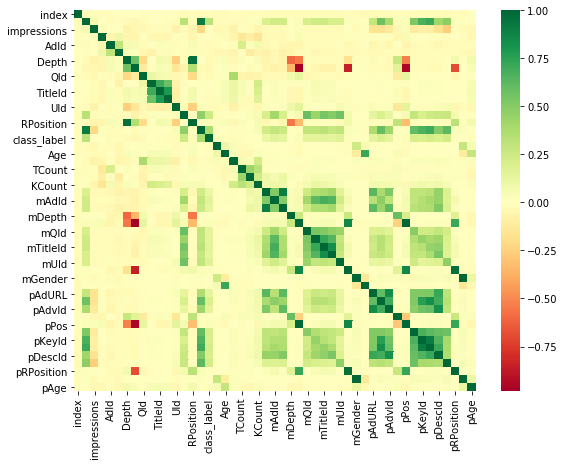

In [6]:
# Heatmap of correlation plot
plt.figure(figsize=(9,7))
sns.heatmap(x_train.corr(), cmap='RdYlGn')
plt.show()

In [7]:
# Dropping off the class labels and index columns

x_train = x_train.drop('class_label', axis=1)
x_train = x_train.drop('index', axis=1)

x_test = x_test.drop('class_label', axis=1)
x_test = x_test.drop('index', axis=1)

print(x_train.shape)
print(x_test.shape)

(974891, 47)
(243708, 47)


### Binary Sparse features

In [8]:
# We also expand query’s tokens, title’s tokens, description’s tokens and keyword’s tokens into binary features.
# That is, if a token occurs in title, query, description or keyword, the corresponding value in the feature vector will be
# 1, or 0 otherwise



# one-hot encoding of Keyword feature.
train = [str (item) for item in x_train['KeyId']]
test = [str (item) for item in x_test['KeyId']]
keyword_vectorizer = CountVectorizer(binary=True)
bow_train_keyword = keyword_vectorizer.fit_transform(train)
bow_test_keyword = keyword_vectorizer.transform(test)

#train = [str (item) for item in x_train['Gender']]
#test = [str (item) for item in x_test['Gender']]
#user_gender_vectorizer = CountVectorizer(binary=True)
#bow_train_gender = user_gender_vectorizer.fit_transform(train)
#bow_test_gender = user_gender_vectorizer.transform(test)

#train = [str (item) for item in x_train['Age']]
#test = [str (item) for item in x_test['Age']]
#user_age_vectorizer = CountVectorizer(binary=True)
#bow_train_age = user_age_vectorizer.fit_transform(train)
#bow_test_age = user_age_vectorizer.transform(test)

train = [str (item) for item in x_train['QId']]
test = [str (item) for item in x_test['QId']]
query_vectorizer = CountVectorizer(binary=True)
bow_train_query = query_vectorizer.fit_transform(train)
bow_test_query = query_vectorizer.transform(test)

train = [str (item) for item in x_train['DescId']]
test = [str (item) for item in x_test['DescId']]
desc_vectorizer = CountVectorizer(binary=True)
bow_train_desc = desc_vectorizer.fit_transform(train)
bow_test_desc = desc_vectorizer.transform(test)

train = [str (item) for item in x_train['TitleId']]
test = [str (item) for item in x_test['TitleId']]
title_vectorizer = CountVectorizer(binary=True)
bow_train_title = title_vectorizer.fit_transform(train)
bow_test_title = title_vectorizer.transform(test)

train = [str (item) for item in x_train['AdId']]
test = [str (item) for item in x_test['AdId']]
add_vectorizer = CountVectorizer(binary=True)
bow_train_add = add_vectorizer.fit_transform(train)
bow_test_add = add_vectorizer.transform(test)

train = [str (item) for item in x_train['AdvId']]
test = [str (item) for item in x_test['AdvId']]
adv_vectorizer = CountVectorizer(binary=True)
bow_train_adv = adv_vectorizer.fit_transform(train)
bow_test_adv = adv_vectorizer.transform(test)

train = [str (item) for item in x_train['AdURL']]
test = [str (item) for item in x_test['AdURL']]
adurl_vectorizer = CountVectorizer(binary=True)
bow_train_adurl = adurl_vectorizer.fit_transform(train)
bow_test_adurl = adurl_vectorizer.transform(test)

In [9]:
x_train_sparse = csr_matrix(x_train.values)
train_data = hstack((x_train_sparse,bow_train_keyword,bow_train_query,bow_train_desc,bow_train_title,bow_train_add,bow_train_adv,bow_train_adurl))

x_test_sparse = csr_matrix(x_test.values)
test_data = hstack((x_test_sparse,bow_test_keyword,bow_test_query,bow_test_desc,bow_test_title,bow_test_add,bow_test_adv,bow_test_adurl))

In [10]:
test_data

<243708x820135 sparse matrix of type '<class 'numpy.float64'>'
	with 11984232 stored elements in COOrdinate format>

In [ ]:
#x_train.to_csv('../Data/train_1M_num_feats_mod.csv',index=False)
#x_test.to_csv('../Data/test_1M_num_feats_mod.csv',index=False)

In [11]:
train_normalized = normalize(train_data, axis=1)
test_normalized = normalize(test_data , axis=1)

In [ ]:
#x_train.to_csv('../Data/train_1M_num_feats_mod.csv',index=False)
#x_test.to_csv('../Data/test_1M_num_feats_mod.csv',index=False)

In [12]:
# To plot confusion matrix.
def plot_confusion_matrix(y_test, pred):
    C = confusion_matrix(y_test, pred)
    
    labels = [1,2]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(10,4))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

### LOGISTIC REGRESSION MODEL

In [13]:
# To print scores
def print_metrics_measure(pred,y_test):
    
     # Plotting Confusion_Matrix
    plot_confusion_matrix(y_test, pred)
    
    #Score
    score = metrics.roc_auc_score(y_test, pred)*100
    print('\nThe score of the LR [Test data] : ',(score))
    
    print("----"*20)

In [14]:
def gridsearch(train_std_data,test_std_data,y_1,y_test):
    
    cv_scores = []
    tuned_parameters = [{'C': [0.001,0.01,0.1,1,10,100,1000], "penalty":["l1","l2"]}]
    k = StratifiedKFold(n_splits=3)
    grid_lr = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'roc_auc', cv=k, return_train_score=True)
    grid_lr.fit(train_std_data,y_1)
    print("Best Estimator: ")
    model = grid_lr.best_estimator_
    print(model)
    print("******"*20)
    
    C = [0.001,0.01,0.1,1,10,100,1000]
    
    if grid_lr.best_params_['penalty'] == 'l1':
        cv_scores = (grid_lr.cv_results_['mean_train_score'][::2])
    else:
        cv_scores = (grid_lr.cv_results_['mean_train_score'][1::2])

    plt.plot(C, cv_scores)
    
    for xy in zip(C, np.round(cv_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
    plt.xlabel('Hyperparameters')
    plt.ylabel('cv_scores')
    plt.title("CV_SCORES of Trian")
    plt.grid()
    plt.show()
    
    #print("Best Hyperparameter is: ",grid_lr.best_params_['C'])
    
    
    if grid_lr.best_params_['penalty'] == 'l1':
        cv_scores = (grid_lr.cv_results_['mean_test_score'][::2])
    else:
        cv_scores = (grid_lr.cv_results_['mean_test_score'][1::2])

    plt.plot(C, cv_scores)
    
    for xy in zip(C, np.round(cv_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
        
    plt.xlabel('Hyperparameters')
    plt.ylabel('cv_scores')
    plt.title("CV_SCORES of Test")
    plt.grid()
    plt.show()
    
    #print("Best Hyperparameter is: ",grid_lr.best_params_['C'])
    
    print("******"*20)
    
    pred = grid_lr.predict(test_std_data)
    print_metrics_measure(pred,y_test)
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = grid_lr.predict_proba(test_std_data)
    lr_probs = lr_probs[:, 1]
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    return model

Best Estimator: 
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
************************************************************************************************************************


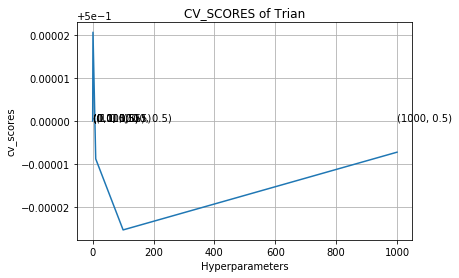

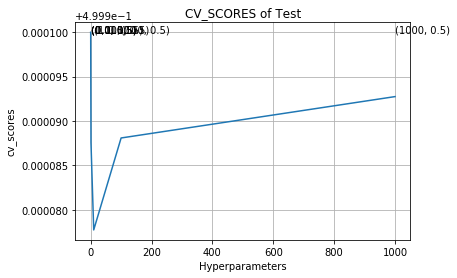

************************************************************************************************************************
-------------------- Confusion matrix --------------------


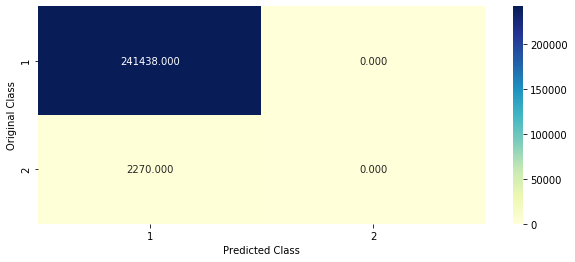


The score of the LR [Test data] :  50.0
--------------------------------------------------------------------------------


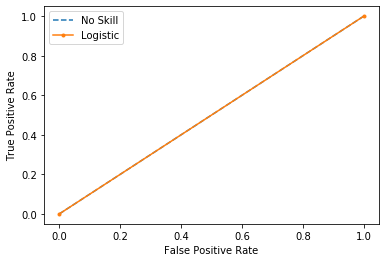

In [33]:
lr_grid_bow = gridsearch(train_normalized,test_normalized,y_train,y_test)

### Observations:

1. We used grid search inorder to tune the hyperparameters(C, penalty).


2. The scorimg metric we used here is auc which is equivalent to the probability that a random pair of a positive sample (clicked ad)
   and a negative one (unclicked ad) is ranked correctly.
   
    
3. We tried to plot the train and test cv scores inorder to understand which value of C is good.


4. With better hyperparameter tuning, the Logistic Regression model scored 50%. From the confusion matrix we can understand that
   for any query point it is trying to output class 0 (if imbalanced). If we tries to balance the dataset using class_weight=balanced, it is trying to output class 1

##### The easiest way to successfully generalize a model is by using more data. 

##### The problem is that out-of-the-box classifiers like logistic regression or random forest tend to generalize by discarding the rare class

### SVM

In [34]:
# To print scores
def print_metrics_measure(y_train,y_test,pred_train,pred_test):
    
     # Plotting Confusion_Matrix
    plot_confusion_matrix(y_test, pred_test)
    
    #Roc_Auc
    auc_train = metrics.roc_auc_score(y_train, pred_train)*100
    auc_test = metrics.roc_auc_score(y_test, pred_test)*100
    print('\nTrain auc_score : ',(auc_train))
    print('\nTest auc_score : ',(auc_test))


In [35]:
train_normalized = normalize(x_train, axis=1)
test_normalized = normalize(x_test , axis=1)

In [ ]:
tuned_parameters = {'C': [0.1], 'gamma': [0.1]}
#k = StratifiedKFold(n_splits=5)
random_lr = RandomizedSearchCV(SVC(kernel='rbf'), tuned_parameters, scoring = 'roc_auc', cv=2)
random_lr.fit(train_normalized,y_train)
print("Best Estimator: ")
model = random_lr.best_estimator_
print(model)
print("******"*20)
pred_train = random_lr.predict(train_normalized)
pred_test = random_lr.predict(test_normalized)

print_metrics_measure(y_train,y_test,pred_train,pred_test)


In [ ]:
tuned_parameters = {'C': [0.001,0.1,1], 'gamma': [0.001,0.1,1]}
#k = StratifiedKFold(n_splits=5)
random_lr = RandomizedSearchCV(SVC(kernel='rbf'), tuned_parameters, scoring = 'roc_auc', cv=2)
random_lr.fit(train_normalized,y_train)
print("Best Estimator: ")
model = random_lr.best_estimator_
print(model)
print("******"*20)
pred_train = random_lr.predict(train_normalized)
pred_test = random_lr.predict(test_normalized)

print_metrics_measure(y_train,y_test,pred_train,pred_test)


Best Estimator: 
LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
************************************************************************************************************************
-------------------- Confusion matrix --------------------


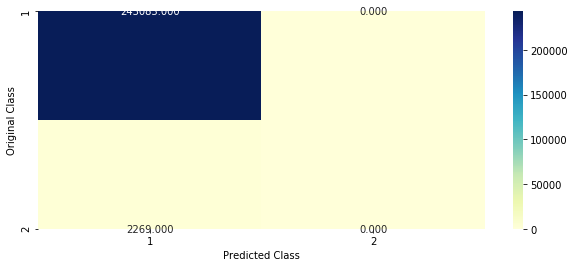


Train auc_score :  50.0

Test auc_score :  50.0


In [0]:
from sklearn.svm import LinearSVC
tuned_parameters = {'C': [0.001,0.1,1,10,100]}
#k = StratifiedKFold(n_splits=5)
random_lr = RandomizedSearchCV(LinearSVC(), tuned_parameters, scoring = 'roc_auc', cv=2)
random_lr.fit(train_normalized,y_train)
print("Best Estimator: ")
model = random_lr.best_estimator_
print(model)
print("******"*20)
pred_train = random_lr.predict(train_normalized)
pred_test = random_lr.predict(test_normalized)

print_metrics_measure(y_train,y_test,pred_train,pred_test)


#Decision Tree

In [15]:
cv_scores = []
tuned_parameters = {'max_depth': [25,40,75,100]}
#k = StratifiedKFold(n_splits=5)
random_dt = RandomizedSearchCV(DecisionTreeClassifier(), tuned_parameters, scoring = 'roc_auc', cv=2)
random_dt.fit(x_train,y_train)
print("Best Estimator: ")
model_dt = random_dt.best_estimator_
print(model_dt)
print("******"*20)
pred_train = random_dt.predict(x_train)
pred_test = random_dt.predict(x_test)

print_metrics_measure(y_train,y_test,pred_train,pred_test)


Best Estimator: 
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=25, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
************************************************************************************************************************


TypeError: print_metrics_measure() takes 2 positional arguments but 4 were given

#RandomForest

Best Estimator: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=35, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
************************************************************************************************************************
-------------------- Confusion matrix --------------------


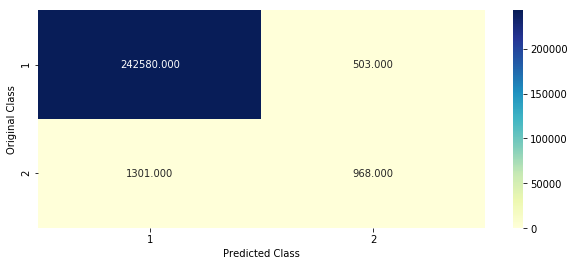


Train auc_score :  78.54172238885232

Test auc_score :  71.22752020850304


In [0]:
cv_scores = []
tuned_parameters = {'n_estimators': [100,200,400,500], 'max_depth': [25,35,50,80]}
#k = StratifiedKFold(n_splits=5)
random_lr = RandomizedSearchCV(RandomForestClassifier(), tuned_parameters, scoring = 'roc_auc', cv=2)
random_lr.fit(x_train,y_train)
print("Best Estimator: ")
model_rdlr = random_lr.best_estimator_
print(model_rdlr)
print("******"*20)
pred_train = random_lr.predict(x_train)
pred_test = random_lr.predict(x_test)

print_metrics_measure(y_train,y_test,pred_train,pred_test)

### XGBOOST MODEL

#### To model, I used only average (click-through rate and pseudo click-through rate) features (47 features). Only using these features gave me better results(74% test auc) than using all the features we engineered above(67% Test auc - tried in different notebook). 


In [0]:
x_train.columns

Index(['clicks', 'impressions', 'AdURL', 'AdId', 'AdvId', 'Depth', 'Pos',
       'QId', 'KeyId', 'TitleId', 'DescId', 'UId', 'CTR', 'RPosition', 'pCTR',
       'Gender', 'Age', 'QCount', 'TCount', 'DCount', 'KCount', 'mAdURL',
       'mAdId', 'mAdvId', 'mDepth', 'mPos', 'mQId', 'mKeyId', 'mTitleId',
       'mDescId', 'mUId', 'mRPosition', 'mGender', 'mAge', 'pAdURL', 'pAdId',
       'pAdvId', 'pDepth', 'pPos', 'pQId', 'pKeyId', 'pTitleId', 'pDescId',
       'pUId', 'pRPosition', 'pGender', 'pAge'],
      dtype='object')

In [0]:
x_train.head()

,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,...,pDepth,pPos,pQId,pKeyId,pTitleId,pDescId,pUId,pRPosition,pGender,pAge
0,0.0,1.0,14340390157469405184,4803006,23777,1,1,22997071,1929,2153,...,0.049664,0.049843,0.049342,0.049461,0.049586,0.049586,0.049278,0.049664,0.049866,0.049710
1,0.0,2.0,14340390157469405184,4803006,23777,2,1,2293,1929,2153,...,0.049693,0.049843,0.049319,0.049461,0.049586,0.049586,0.049278,0.050043,0.049866,0.049710
2,0.0,1.0,14340390157469405184,4803006,23777,3,1,2293,1929,2153,...,0.049558,0.049843,0.049319,0.049461,0.049586,0.049586,0.050083,0.049986,0.049426,0.050099
3,0.0,1.0,14340390157469405184,4803006,23777,2,1,2293,1929,2153,...,0.049693,0.049843,0.049319,0.049461,0.049586,0.049586,0.049342,0.050043,0.049426,0.049710
4,0.0,1.0,14340390157469405184,4803006,23777,2,1,2293,1929,2153,...,0.049693,0.049843,0.049319,0.049461,0.049586,0.049586,0.049041,0.050043,0.049866,0.049629


In [0]:
x_test.head()

,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,...,pDepth,pPos,pQId,pKeyId,pTitleId,pDescId,pUId,pRPosition,pGender,pAge
0,0.0,1.0,15349556856043354112,22098439,36855,3,3,12875,89237,190,...,0.049664,0.049843,0.049342,0.049461,0.049586,0.049586,0.049278,0.049664,0.049866,0.049710
1,0.0,1.0,15349556856043354112,22098439,36855,3,2,12875,89237,190,...,0.049693,0.049843,0.049319,0.049461,0.049586,0.049586,0.049278,0.050043,0.049866,0.049710
2,0.0,1.0,15349556856043354112,22098439,36855,2,2,52877,89237,190,...,0.049558,0.049843,0.049319,0.049461,0.049586,0.049586,0.050083,0.049986,0.049426,0.050099
3,0.0,1.0,15349556856043354112,22098457,36855,2,1,33318,9782,190,...,0.049693,0.049843,0.049319,0.049461,0.049586,0.049586,0.049342,0.050043,0.049426,0.049710
4,0.0,1.0,15349556856043354112,22098457,36855,1,1,33318,9782,190,...,0.049693,0.049843,0.049319,0.049461,0.049586,0.049586,0.049041,0.050043,0.049866,0.049629


The train score is: 0.9972541957905423
The test score is: 0.9962498466876859


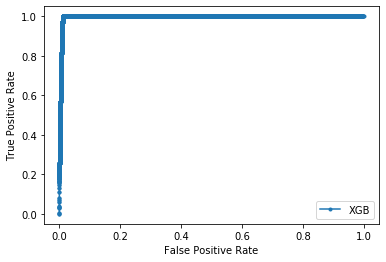

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [21]:
start = datetime.now()

x_cfl=XGBClassifier(n_estimators=455,max_depth=3,learning_rate=0.1373,colsample_bytree=0.65,subsample=1)
x_cfl.fit(x_train,y_train,verbose=True)

predict_y = x_cfl.predict_proba(x_train)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_train, predict_y)
print ("The train score is:",metrics.auc(fpr, tpr))

predict_y = x_cfl.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_y)
print("The test score is:",metrics.auc(fpr, tpr))
plt.plot(fpr, tpr, marker='.', label='XGB')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    # show the legend
plt.legend()
    # show the plot
plt.show()

plot_confusion_matrix(y_test, predict_y)

print("-"*20, "Feature Importance", "-"*20)

features = x_train.columns
importances = x_cfl.feature_importances_
indices = (np.argsort(importances))[-10:]
plt.figure(figsize=(8,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

print("Time taken to run this cell :", datetime.now() - start)

In [20]:
predict_y

array([[9.9999994e-01, 8.1572502e-08],
       [9.9999994e-01, 8.2528388e-08],
       [9.9999988e-01, 1.0808868e-07],
       ...,
       [1.0000000e+00, 2.2210140e-08],
       [1.0000000e+00, 2.4207301e-08],
       [9.9999994e-01, 3.1659649e-08]], dtype=float32)

### Observations:

1. XGBoost is already a good starting point if the classes are not skewed too much, because it internally takes care that the bags it trains on are not imbalanced. But then again, the data is resampled, it is just happening secretly.


2. We tried the hyperparameter tuning(n_estimators,max_depth,learning_rate,colsample_bytree,subsample) in differant notebook, used the values here, tried to tweak them and could see better results than Logistic regression.


3. The scorimg metric we used here is auc which is equivalent to the probability that a random pair of a positive sample (clicked ad) and a negative one (unclicked ad) is ranked correctly.


4. We tried to plot the confusion matrix inorder to better understand the results.


5.  We tried to get feature importance to understand which features are important. Here we printed top 10 important features. We could see from the above feature importance plot that even raw ID features are very important.

6. We tried using all the features engineered above, but using averageor mean CTR features only gave us better results.


6. Here we got the result train score = 0.75 and test score  = 0.74 (improved just by tweaking the parameters)

### Conclusion:

In [0]:
x = PrettyTable()

x.field_names = ["Model","Train Score %","Test Score %"]
x.add_row([ "Logistic Regression",50,50])
x.add_row([ "SVM(RBF_kernel)",50,50])
x.add_row([ "SVM(Linear)",50,50])
x.add_row([ "Decision Tree",76.46,70.75])
x.add_row([ "Random Forest",78.54,71.22])
x.add_row([ "XGBOOST",75.67,74.78])

print(x)

+---------------------+---------------+--------------+
|        Model        | Train Score % | Test Score % |
+---------------------+---------------+--------------+
| Logistic Regression |       50      |      50      |
|   SVM(RBF_kernel)   |       50      |      50      |
|     SVM(Linear)     |       50      |      50      |
|    Decision Tree    |     76.46     |    70.75     |
|    Random Forest    |     78.54     |    71.22     |
|       XGBOOST       |     75.67     |    74.78     |
+---------------------+---------------+--------------+


From the above table we could observe that XGBOOST model beats Logistic Regression model as out of the box classifiers like Logistic Regression discards the rare classes.

### Links:

How to use multiple parameters in apply function?

https://stackoverflow.com/questions/34279378/python-pandas-apply-function-with-two-arguments-to-columns/34279543

How to combine two lists as key and value pairs

https://stackoverflow.com/questions/209840/convert-two-lists-into-a-dictionary-in-python

how to deal with highly imbalanced data?

https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html
https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

Documentation:
Metrics:

https://scikit-learn.org/stable/modules/classes.html

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
https://www.dataschool.io/roc-curves-and-auc-explained/


Referred:

https://jyunyu.csie.org/docs/pubs/kddcup2012paper.pdf 



In [0]:
'''<!--Table-->
<table id="tablePreview" class="table table-hover table-striped">
<!--Table head-->
  <thead>
    <tr>
      <th></th>
      <th><b>Model</b></th>
      <th><b>Train Score %</b></th>
      <th><b>Test Score %</b></th>
      
    </tr>
  </thead>
  <!--Table head-->
  <!--Table body-->
  <tbody>
    <tr>
      <th scope="row">1</th>
      <td>Logistic Regression</td>
      <td>50</td>
      <td>50</td>
    </tr>
    <tr>
      <th scope="row">2</th>
      <td>SVM(RBF_kernel)</td>
      <td>50</td>
      <td>50</td>
    </tr>
    <tr>
      <th scope="row">3</th>
      <td>SVM(Linear) </td>
      <td>50</td>
      <td>50</td>
    </tr>
       <tr>
      <th scope="row">4</th>
      <td>Decision Tree</td>
      <td>76.46</td>
      <td>70.75</td>
    </tr>
        <tr>
      <th scope="row">5</th>
      <td>Random Forest</td>
      <td>78.54</td>
      <td>71.22</td>
    </tr>
        <tr>
      <th scope="row">6</th>
      <td>XGBoost</td>
      <td>75.67</td>
      <td>74.78</td>
    </tr>
    
  </tbody>
  <!--Table body-->
</table>
<!--Table-->'''

'<!--Table-->\n<table id="tablePreview" class="table table-hover table-striped">\n<!--Table head-->\n  <thead>\n    <tr>\n      <th></th>\n      <th><b>Model</b></th>\n      <th><b>Train Score %</b></th>\n      <th><b>Test Score %</b></th>\n      \n    </tr>\n  </thead>\n  <!--Table head-->\n  <!--Table body-->\n  <tbody>\n    <tr>\n      <th scope="row">1</th>\n      <td>Logistic Regression</td>\n      <td>50</td>\n      <td>50</td>\n    </tr>\n    <tr>\n      <th scope="row">2</th>\n      <td>SVM(RBF_kernel)</td>\n      <td>50</td>\n      <td>50</td>\n    </tr>\n    <tr>\n      <th scope="row">3</th>\n      <td>SVM(Linear) </td>\n      <td>50</td>\n      <td>50</td>\n    </tr>\n       <tr>\n      <th scope="row">4</th>\n      <td>Decision Tree</td>\n      <td>76.46</td>\n      <td>70.75</td>\n    </tr>\n        <tr>\n      <th scope="row">5</th>\n      <td>Random Forest</td>\n      <td>78.54</td>\n      <td>71.22</td>\n    </tr>\n        <tr>\n      <th scope="row">6</th>\n      <td>